In [1]:
# Torch and related packages
import torch
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from PIL import Image

# Math and plot utils
import numpy as np
import matplotlib.pyplot as plt

# Useful utilities
import os
import time

# Our model which we train
from models.fast_scnn import FastSCNN

# Custom Utilities
from utils.dataset import IGVCDataset
from utils.train_util import train_net
from utils.common_utils import load_model, output_mask, save_model, img_to_mask

In [2]:
gpuid = 0
print(torch.cuda.get_device_properties(gpuid))
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
print(device)

_CudaDeviceProperties(name='GeForce GTX 1070 with Max-Q Design', major=6, minor=1, total_memory=8119MB, multi_processor_count=16)
cuda:0


In [3]:
def show_lanes(image, label):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    label = label.numpy().transpose((1, 2, 0))
    label = std * label + mean
    label = np.clip(label, 0, 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap='jet', alpha=0.5)
    plt.pause(0.001)

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=240),
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

In [5]:
dataloaders = {}
datasets = {}
datasizes = {}

datasets['train'] = IGVCDataset(imgs_dir='data_train/images', labels_dir='data_train/labels', transform=train_transforms)
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=2)
datasizes['train'] = len(datasets['train'])

datasets['val'] = IGVCDataset(imgs_dir='data_val/images', labels_dir='data_val/labels', transform=test_transforms)
dataloaders['val'] = torch.utils.data.DataLoader(datasets['val'], batch_size=4, shuffle=True, num_workers=2)
datasizes['val'] = len(datasets['val'])

datasets['test'] = IGVCDataset(imgs_dir='data_test/images', labels_dir='data_test/labels', transform=test_transforms)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=4, shuffle=False, num_workers=2)
datasizes['test'] = len(datasets['test'])

print(datasizes)

{'train': 339, 'val': 201, 'test': 434}


In [6]:
model = FastSCNN(in_channel=1, num_classes=2).to(device)

In [7]:
#load_model(model, './model')

In [8]:
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1, 80], dtype=torch.float).to(device))

model = train_net(model, dataloaders, datasizes, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=20)
print('Training Done.')

Epoch 0/19
----------
train Loss: 0.5310 Acc: 164375.2330
val Loss: 0.4515 Acc: 268323.7363

Epoch 1/19
----------
train Loss: 0.4057 Acc: 250287.4012
val Loss: 0.4185 Acc: 253714.0796

Epoch 2/19
----------
train Loss: 0.3508 Acc: 253282.9823
val Loss: 0.3826 Acc: 247650.1343

Epoch 3/19
----------
train Loss: 0.3381 Acc: 256752.3835
val Loss: 0.3849 Acc: 275240.3085

Epoch 4/19
----------
train Loss: 0.3246 Acc: 254913.0000
val Loss: 0.3351 Acc: 257845.3085

Epoch 5/19
----------
train Loss: 0.3012 Acc: 258147.7817
val Loss: 0.3226 Acc: 247306.6766

Epoch 6/19
----------
train Loss: 0.2920 Acc: 260446.9882
val Loss: 0.3016 Acc: 265936.8060

Epoch 7/19
----------
train Loss: 0.2804 Acc: 261408.1888
val Loss: 0.2929 Acc: 256300.2687

Epoch 8/19
----------
train Loss: 0.2760 Acc: 262464.1504
val Loss: 0.3370 Acc: 266758.6567

Epoch 9/19
----------
train Loss: 0.2526 Acc: 263597.2478
val Loss: 0.2692 Acc: 263387.1741

Epoch 10/19
----------
train Loss: 0.2473 Acc: 262889.1917
val Loss: 0

TypeError: Invalid dimensions for image data

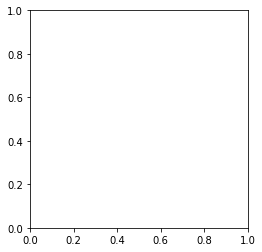

In [9]:
dataiter = iter(dataloaders['train'])
img, label = dataiter.next()
img, label = dataiter.next()
img, label = dataiter.next()
img, label = dataiter.next()
plt.imshow(img[1])
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()
plt.imshow(img[2].permute(1,2,0))
#show_lanes(utils.make_grid(img), utils.make_grid(label))
plt.show()

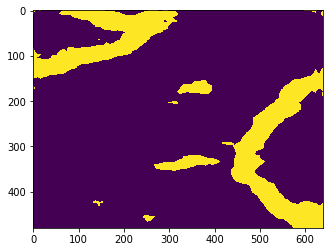

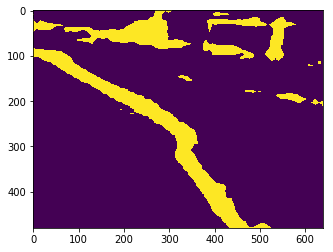

In [10]:
with torch.no_grad():
    pred = output_mask(img, model, device)
    plt.imshow(pred[1])
    plt.show()
    plt.imshow(pred[2])
    plt.show()
    #plt.imshow(img[0].detach().cpu().permute(1, 2, 0))

In [11]:
with torch.no_grad():
    start_time = time.time()
    dataiter = iter(dataloaders['test'])
    for i in range(100):
        if i == 0:
            lat_1 = time.time()
        img, label = dataiter.next()
        pred = output_mask(img, model, device)
        if i == 0:
            lat_2 = time.time()
    end_time = time.time()

print('Results are as following. Tested on GTX 1070 Max-Q.')
print('Time for 400 Images : ', end_time - start_time, 'seconds')
print('FPS (GTX 1070 Max Q) : ', 400/(end_time - start_time), 'fps')
print('Latency : ', lat_2 - lat_1, 'seconds')

Results are as following. Tested on GTX 1070 Max-Q.
Time for 400 Images :  4.64046573638916 seconds
FPS (GTX 1070 Max Q) :  86.19824447001479 fps
Latency :  0.15143084526062012 seconds


In [12]:
save_model(model, './model_gray_2')

Model saved to  ./model_gray_2


In [13]:
test_transforms = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], 
                         std=[0.5])
])

In [14]:
mask = img_to_mask('web_images/input/4.jpg', model, test_transforms, device)

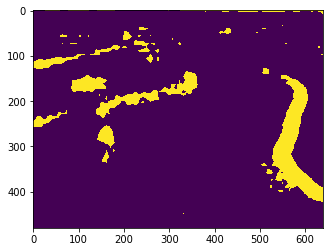

In [15]:
plt.imshow(mask[0])
plt.show()